<a href="https://colab.research.google.com/github/juagarmar/Python/blob/master/Data_Science_Assessment_JuanPabloGarciaMartinez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
import math
from datetime import datetime
import matplotlib.pyplot as plt
import json
from graphviz import Digraph
from IPython.display import Image

## Defining the working directory or connection in case is needed

In [ ]:
 # setting the path as working directoy and saving it as "path"
 path='/content/'

## JSON Profiling for Dataset

In order to create more accessible code and make it more amendable to future changes, we are going to build a JSON file for profiling. In this JSON profile, we will add all the relevant information about our dataset. If in the future the datasets change, we would only need to edit the profiles to accommodate the new format.

### The JSON file will include:

- **Name**: To identify each variable. Ideally, we should have another name assigned to the pipeline to handle name changes effortlessly.
- **Type**: Data type to cross-check at the ingestion module, ensuring each variable is ingested with the correct data type.
- **Desc**: Name description so we can use the descriptive name to produce the final output and make it accessible to the general public.
- **Dformat**: Date format, as date is a sensitive data type that allows several types of formatting, which also depends on the regions. We will ensure the date format is consistent across the pipeline.
- **Relationships**: We will indicate what relationships are needed to join the tables and produce a consistent single table as output. This could potentially indicate which parameters can be used as unique identifiers.


In [ ]:
#Define the structure of the tables and relationships
data_diagram = {
  "tables": [
    {
      "name": "cases_medical",
      "columns": [
        {"name": "idno", "type": "integer", "desc":"patient_id"},
        {"name": "evntdate", "type": "date", "dformat":"ddmmmyyyy", "desc":"event_date"},
        {"name": "description", "type": "string", "desc":"description"},
        {"name": "line", "type": "integer", "desc":"line"},
        {"name": "medcode", "type": "string", "desc":"medcode"}
      ]
    },
    {
      "name": "stroke_codes",
      "columns": [
        {"name": "medcode", "type": "string", "desc":"medcode"}
      ]
    },
    {
      "name": "cases_personal",
      "columns": [
        {"name": "idno", "type": "integer", "desc":"patient_id"},
        {"name": "dob", "type": "date", "dformat":"ddmmmyyyy", "desc":"date_of_birth"},
        {"name": "sex", "type": "binary", "sex":"sex"}
      ]
    }
  ],
  "relationships": [
    {
      "from_table": "cases_medical",
      "from_column": "medcode",
      "to_table": "stroke_codes",
      "to_column": "medcode",
      "relationship_type": "one-to-many"
    },
    {
      "from_table": "cases_medical",
      "from_column": "idno",
      "to_table": "cases_personal",
      "to_column": "idno",
      "relationship_type": "many-to-one"
    }
  ]
}
# write the data to a JSON file under path
with open(path + 'relationships.json', 'w') as json_file:
    json.dump(data_diagram, json_file, indent=4)

print(f"JSON file has been created and saved to {path}")

JSON file has been created and saved to /content/


Display the diagram:

This is very useful to ensure the logic is correct and improve readability of the code

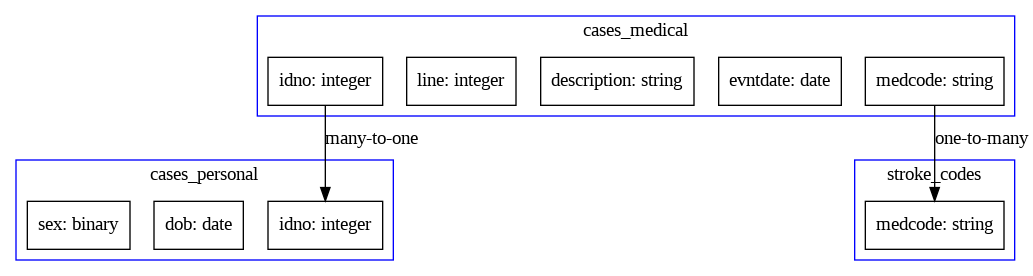

In [ ]:
# create an empty diagram
dot = Digraph(comment='ER Diagram')

#add tables and columns
for table in data_diagram['tables']:
    table_name = table['name']
    with dot.subgraph(name=f'cluster_{table_name}') as c:
        c.attr(label=table_name)
        c.attr(color='blue')
        for column in table['columns']:
            col_name = column['name']
            col_type = column['type']
            c.node(f'{table_name}.{col_name}', label=f'{col_name}: {col_type}', shape='box')

# add relationships
for rel in data_diagram['relationships']:
    from_table = rel['from_table']
    from_column = rel['from_column']
    to_table = rel['to_table']
    to_column = rel['to_column']
    dot.edge(f'{from_table}.{from_column}', f'{to_table}.{to_column}', label=rel['relationship_type'])

dot.render(path + '/ER_diagram', format='png')
Image(path + '/ER_diagram.png')

## Data Ingestion

In [ ]:
# we ensure json profile file is loaded
json_path = os.path.join(path, 'relationships.json')
with open(json_path, 'r') as json_file:
    data_diagram = json.load(json_file)

In [ ]:
# function to dynamically create dataframes based on table definitions in the JSON under a specific path
def create_dataframes_from_files(base_path, table_definitions):
    dataframes = {}

    for table in table_definitions:
        table_name = table['name']
        file_path = os.path.join(base_path, f'{table_name}.txt')

        if os.path.exists(file_path):
            df = pd.read_csv(file_path, delimiter='\t')
            dataframes[table_name] = df
        else:
            #show error
            print(f'File for table {table_name} does not exist at path {file_path}')

    return dataframes

In [ ]:
# use function to create dataframes dynamically
dataframes = create_dataframes_from_files(path, data_diagram['tables'])

Disclaimer: As creating a full dynamic pipeline is time-consuming, I will also create independent data frames to explore the data individually. Once the individual exploration is complete, I will link the data frames again to continue the dynamic approach

In [ ]:
# Display the dataframes and create dynamic variables
# at this step I would cross check all the data types with the data type at the json reference "relationship.json" more time needed.
# instead we will do an exploratory manual check to make sure all the data types are correct
for table_name, df in dataframes.items():
    globals()[table_name] = df  #create a variable with the table name

## Exploratory analysis of the data (Not dynamic):

In [ ]:
# this is a function from my personal github profile to explore dataframes:
def analyze_dataframe(df) -> pd.DataFrame:
    analysis_df = pd.DataFrame(index=df.columns, columns=['Data Type', 'Column Type', 'Missing Data Count', 'Distinct Values Count', 'First 5 Distinct Values'])

    for column in df.columns:
        data_type = df[column].dtype.name
        distinct_values = df[column].dropna().unique()
        distinct_values_count = len(distinct_values)
        first_5_values = ', '.join([str(v) for v in distinct_values[:5]])
        analysis_df.loc[column, 'Data Type'] = data_type
        analysis_df.loc[column, 'Missing Data Count'] = df[column].isnull().sum()
        analysis_df.loc[column, 'Distinct Values Count'] = distinct_values_count
        analysis_df.loc[column, 'First 5 Distinct Values'] = first_5_values

        if data_type in ['object', 'category', 'bool']:
            analysis_df.loc[column, 'Column Type'] = 'Categorical'
        else:
            if distinct_values_count == 2:
                analysis_df.loc[column, 'Column Type'] = 'Binary'
            else:
                analysis_df.loc[column, 'Column Type'] = 'Numerical'

    return analysis_df

In [ ]:
analyze_dataframe(cases_personal)

,Data Type,Column Type,Missing Data Count,Distinct Values Count,First 5 Distinct Values
sex,int64,Binary,0,2,"1, 2"
dob,datetime64[ns],Numerical,0,46,"1939-07-01 00:00:00, 1923-07-01 00:00:00, 1922..."
idno,int64,Numerical,0,377,"1, 2, 3, 4, 5"


By printing this summaries we can ensure the data types are correct and the number of distint values match the data types. Moreover, we can ensure that there is no missing data. We are aware that in dates showing 01jun1900 represent missing data and we will deal with that later.

In [ ]:
analyze_dataframe(stroke_codes)

,Data Type,Column Type,Missing Data Count,Distinct Values Count,First 5 Distinct Values
medcode,object,Categorical,0,25,"8HBJ.00, G61..00, G61..11, G61..12, G61z.00"


In [ ]:
analyze_dataframe(cases_medical)

,Data Type,Column Type,Missing Data Count,Distinct Values Count,First 5 Distinct Values
medcode,object,Categorical,0,5041,"03AQ.00, 03G..00, 03I..00, 041E.00, 051J.00"
evntdate,datetime64[ns],Numerical,0,5894,"2004-03-16 00:00:00, 2002-12-16 00:00:00, 2000..."
description,object,Categorical,0,4982,"Social worker, Pharmacists, Opticians, Transla..."
idno,int64,Numerical,0,377,"274, 145, 212, 149, 188"
line,int64,Numerical,0,182,"307, 104, 255, 128, 33"


In [ ]:
#let's convert dob and evntdate to date data type
cases_personal['dob'] = pd.to_datetime(cases_personal['dob'], format='%d%b%Y', errors='coerce')
cases_medical['evntdate'] = pd.to_datetime(cases_medical['evntdate'], format='%d%b%Y', errors='coerce')

## Dynamic Data Cleaning of Individual Files

To ensure traceability, we will first create a log file for errors called `errorlog.txt`. In this file, we will store, under the current date, dataframes with all the modifications made to the original file. The cleaned output will be stored in a different location to keep the original files untouched, ensuring traceability in case the process needs to be reviewed or debugged.



In [ ]:
#create log files for errors log
log_file_name = 'errorlog.txt'
log_file_path = os.path.join(path, log_file_name)

with open(log_file_path, 'w') as log_file:
    pass
# keep path in variable
log_file_path_variable = log_file_path
print(f"Log file created at: {log_file_path_variable}")

Log file created at: /content/errorlog.txt


As we already checked manually the consistency of the data types in the previous step, we are now going to focus on the two checks that we think are most relevant: duplicates and missing event dates. To do this in a dynamic way, we will use two different functions.

To ensure our criteria are properly applied, we will establish an order: first checking data consistency and then checking for duplicates.

In [ ]:
# as we already check manually the consistency of the data type we are going to skip this function as time limitation

In [ ]:
def log_dates_and_clean(df, df_name):
    missing_dates = pd.Series(False, index=df.index)


    for column in df.columns:
        if pd.api.types.is_datetime64_any_dtype(df[column]):
            try:
                df[column] = pd.to_datetime(df[column], errors='coerce')
                df[column] = df[column].apply(lambda x: pd.NaT if x == pd.Timestamp('1900-01-01') else x)
                missing_dates = missing_dates | df[column].isna()

            except Exception as e:
                print(f"Could not process column '{column}' as date. Error: {e}")

    #create a column indicating missing date
    missing_date_column = f'missing_date_{df_name}'
    df[missing_date_column] = missing_dates

    #log error in txt file
    missing_rows = df[missing_dates]
    if not missing_rows.empty:
        with open(log_file_path, 'a') as log_file:
            log_file.write(f"Rows with missing dates in {df_name}:\n")
            log_file.write(missing_rows.to_string(index=False))
            log_file.write("\n")

    return df

In [ ]:
# specific function to address duplicated records and log it in the errorlog.txt file.
def remove_duplicates_and_print(df, df_name, subset=None, keep='first'):
    #identify duplicates
    duplicated_records = df[df.duplicated(subset=subset, keep=False)]

    # today's date
    today_date = datetime.now().strftime("%d%b%Y")

    # duplicated records
    if not duplicated_records.empty:
        print("Duplicated records:")
        print(duplicated_records)

        # Log duplicated records to the log file
        with open(log_file_path, 'a') as log_file:
            log_file.write(f"Duplicated records in {df_name} on {today_date}:\n")
            duplicated_records.to_string(log_file)
            log_file.write("\n")
    else:
        print("No duplicates found.")

    #drop duplicates
    df_no_duplicates = df.drop_duplicates(subset=subset, keep=keep)

    print(f"\nDuplicated records logged in: {log_file_path}")

    return df_no_duplicates

In [ ]:
#re-link all the dataframes on a dictionary as orginally:
dataframes = {
    'cases_medical': cases_medical,
    'stroke_codes': stroke_codes,
    'cases_personal': cases_personal
}

We will create a new location under path called "Cleaned_files" to create a clean copy of each table before merging them into a single consistent format

In [ ]:
# create cleaned folder for data sets:
clean_files_path=os.path.join(path, 'cleaned_files')
os.makedirs(clean_files_path, exist_ok=True)

In [ ]:
#apply the functions to each DataFrame in the dictionary and save the results
for table_name, df in dataframes.items():

  print(f"Processing {table_name}")
  df = log_dates_and_clean(df, table_name)
  df = remove_duplicates_and_print(df, table_name)

  #save the cleaned DataFrame as a CSV file
  cleaned_file_path = os.path.join(clean_files_path, f'{table_name}.csv')
  df.to_csv(cleaned_file_path, index=False)

#check the cleaned DataFrames and confirm they are saved
for table_name, df in dataframes.items():
  cleaned_file_path = os.path.join(clean_files_path, f'{table_name}.csv')
  #print(f"\nCleaned DataFrame saved at: {cleaned_file_path}")


print(f"\nDate processing logged in: {log_file_path}")

Processing cases_medical
No duplicates found.

Duplicated records logged in: /content/errorlog.txt
Processing stroke_codes
No duplicates found.

Duplicated records logged in: /content/errorlog.txt
Processing cases_personal
Duplicated records:
     sex        dob  idno  missing_date_cases_personal
376    1 1930-07-01   377                        False
377    1 1930-07-01   377                        False

Duplicated records logged in: /content/errorlog.txt

Date processing logged in: /content/errorlog.txt


We found identical duplicate entries in the `cases_personal` dataframe, which we logged and removed. This is crucial to maintaining the one-to-many relationship and ensuring data consistency. Additionally, we logged, removed, and flagged 85 records in the `medical_case` dataframe to allow for filtering when needed.

# Data Manipulation (Merging)


In [ ]:
cases_medical = pd.read_csv('/content/cleaned_files/cases_medical.csv')
cases_personal = pd.read_csv('/content/cleaned_files/cases_personal.csv')
stroke_codes = pd.read_csv('/content/cleaned_files/stroke_codes.csv')

In [ ]:
#rename columns according to the descriptions in the profile JSON file
for table in data_diagram["tables"]:
    if table["name"] == "cases_medical":
        for column in table["columns"]:
            cases_medical.rename(columns={column["name"]: column.get("desc", column["name"])}, inplace=True)
    elif table["name"] == "cases_personal":
        for column in table["columns"]:
            cases_personal.rename(columns={column["name"]: column.get("desc", column["name"])}, inplace=True)

Due time constrictions I will focusing on specific data manupulation and data visualisation from this point:

In [ ]:
#Convert date columns to datetime
cases_medical['event_date'] = pd.to_datetime(cases_medical['event_date'], errors='coerce')
cases_personal['date_of_birth'] = pd.to_datetime(cases_personal['date_of_birth'], errors='coerce')

In [ ]:
num_true = cases_personal['missing_date_cases_personal'].sum()
print(f"missing values at cases_personal {num_true}")

missing values at cases_personal 0


In [ ]:
num_true = cases_medical['missing_date_cases_medical'].sum()
print(f"missing values at cases_medical {num_true}")

missing values at cases_medical 85


## Add the patients’ personal information to each of their enhanced medical records

In [ ]:
enhanced_cases_medical = cases_medical.merge(cases_personal, on='patient_id', how='left')

##	Generate a binary variable for each enhanced medical record to indicate whether it is a stroke record

In [ ]:
enhanced_cases_medical['is_stroke_record'] = enhanced_cases_medical['medcode'].isin(stroke_codes['medcode']).astype(int)

In [ ]:
enhanced_cases_medical['is_stroke_record'].unique()

array([0, 1])

##	Generate a variable in each enhanced medical record to indicate age at first stroke for that patient.

In [ ]:
#calculate age at each event
enhanced_cases_medical['age_at_event'] = (enhanced_cases_medical['event_date'] - enhanced_cases_medical['date_of_birth']).dt.days // 365
#identify the first stroke event grouping by patient_id at min event date (intermediary calculation table)
first_stroke_dates = enhanced_cases_medical[enhanced_cases_medical['is_stroke_record'] == 1].groupby('patient_id')['event_date'].min().reset_index()
first_stroke_dates.rename(columns={'event_date': 'first_stroke_date'}, inplace=True)

In [ ]:
#merge the first stroke dates back with enhanced_cases_medical dataframe (left join)
enhanced_cases_medical = enhanced_cases_medical.merge(first_stroke_dates, on='patient_id', how='left')

In [ ]:
#calculate age at first stroke (formula)
enhanced_cases_medical['age_at_first_stroke'] = (enhanced_cases_medical['first_stroke_date'] - enhanced_cases_medical['date_of_birth']).dt.days // 365

In [ ]:
#drop the temporary 'first_stroke_date' column (Not necessary)
enhanced_cases_medical.drop(columns=['first_stroke_date'], inplace=True)

In [ ]:
#save
enhanced_cases_medical.to_csv('/content/cleaned_files/enhanced_cases_medical.csv', index=False)

In [ ]:
#final output
enhanced_cases_medical

,medcode,event_date,description,patient_id,line,missing_date_cases_medical,sex,date_of_birth,missing_date_cases_personal,is_stroke_record,age_at_event,age_at_first_stroke
0,03AQ.00,2004-03-16,Social worker,274,307,False,2,1917-07-01,False,0,86.0,87.0
1,03AQ.00,2002-12-16,Social worker,145,104,False,2,1909-07-01,False,0,93.0,94.0
2,03G..00,2000-02-17,Pharmacists,212,255,False,2,1928-07-01,False,0,71.0,NaN
3,03I..00,1996-04-19,Opticians,149,128,False,2,1920-07-01,False,0,75.0,NaN
4,03I..00,1998-03-23,Opticians,188,33,False,2,1914-07-01,False,0,83.0,83.0
...,...,...,...,...,...,...,...,...,...,...,...,...
38493,ZV7B100,2001-09-26,[V]Screening for hypertension,229,406,False,1,1921-07-01,False,0,80.0,NaN
38494,ZV7B100,2000-12-05,[V]Screening for hypertension,229,406,False,1,1921-07-01,False,0,79.0,NaN
38495,ZV7B100,2002-05-01,[V]Screening for hypertension,229,406,False,1,1921-07-01,False,0,80.0,NaN
38496,ZV7B100,2001-10-24,[V]Screening for hypertension,229,406,False,1,1921-07-01,False,0,80.0,NaN


Now that we have a consistent table, there are more checks that would be applicable, such as:

- Checking that the difference between the date of event and the date of birth is reasonable and not negative either. **Important**: We noticed that the date of birth actually represents the year of birth, so numbers greater than -1 could be normal. As we can see below, the description makes reference to pediatric or admin.

In [ ]:
enhanced_cases_medical[enhanced_cases_medical['age_at_event']<0] # Everything looks normal

,medcode,event_date,description,patient_id,line,missing_date_cases_medical,sex,date_of_birth,missing_date_cases_personal,is_stroke_record,age_at_event,age_at_first_stroke
9460,63E2.00,1924-01-26,Normal birth,67,143,False,1,1924-07-01,False,0,-1.0,78.0
15969,931..00,1916-03-30,Lloyd George record folder,336,54,False,1,1916-07-01,False,0,-1.0,83.0
34218,Q406100,1937-05-17,Neonatal conjunctivitis,163,19,False,2,1937-07-01,False,0,-1.0,53.0


## Conclusions after Data Cleaning:

- **Duplicate records in `cases_personal`**: Removing duplicates is key to maintaining a one-to-many relationship. This action is logged under `errorlog.txt`, and a new output has been generated with the clean data under the location `/cleaned_files/`. The goal is to keep track of modifications while keeping the original file intact to ensure traceability.

- **Event dates showing as `01jan1900`**: A total of 38 event dates are logged as `01jan1900`. This date indicates that the number of days logged is 0, potentially showing that the data entry is blank. We have taken two measures in these cases: removing those dates from the dataset and flagging them as missing dates so they can be easily filtered out in data analysis where these dates are a factor.

We also checked:

- There are no duplicate patient IDs in `cases_personal`.
- There are no duplicate codes in `cases_medical`.
- ...

## Data Exploratory analysis

Distribution from sex:

In [ ]:
#drop duplicates
unique_subjects = enhanced_cases_medical.drop_duplicates(subset='patient_id')
#missing dates list
missing_dates_list = enhanced_cases_medical[enhanced_cases_medical['missing_date_cases_medical'] == True]['patient_id']
# Filter
filtered_unique_subjects = unique_subjects[~unique_subjects['patient_id'].isin(missing_dates_list)]

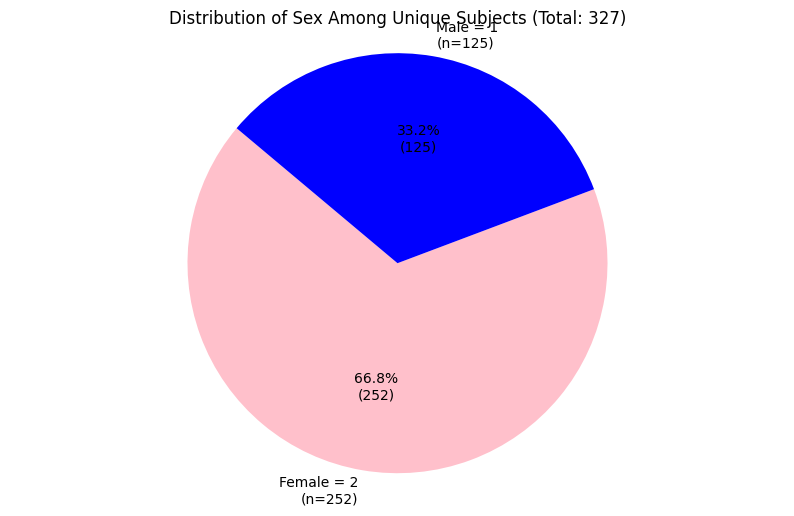

In [ ]:
#drop duplicate patient_id to count unique subjects (not very elegant)
#filter missing dates:
#unique_subjects = enhanced_cases_medical.drop_duplicates(subset='patient_id')
# counts
sex_counts = unique_subjects['sex'].value_counts()
#total number of unique subjects
total_subjects = filtered_unique_subjects['patient_id'].nunique()

def func(pct, allvalues):
    absolute = int(pct / 100. * np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

plt.figure(figsize=(10, 6))
colors = ['pink', 'blue']
labels = [f'Female = 2\n(n={sex_counts[2]})', f'Male = 1\n(n={sex_counts[1]})']
plt.pie(sex_counts, labels=labels, colors=colors, autopct=lambda pct: func(pct, sex_counts), startangle=140)
plt.title(f'Distribution of Sex Among Unique Subjects (Total: {total_subjects})')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the plot
plt.show()

## Note:

We can appreciate an imbalance between males and females, with females making up almost 70% of the dataset.

## Age of First Stroke Histogram:

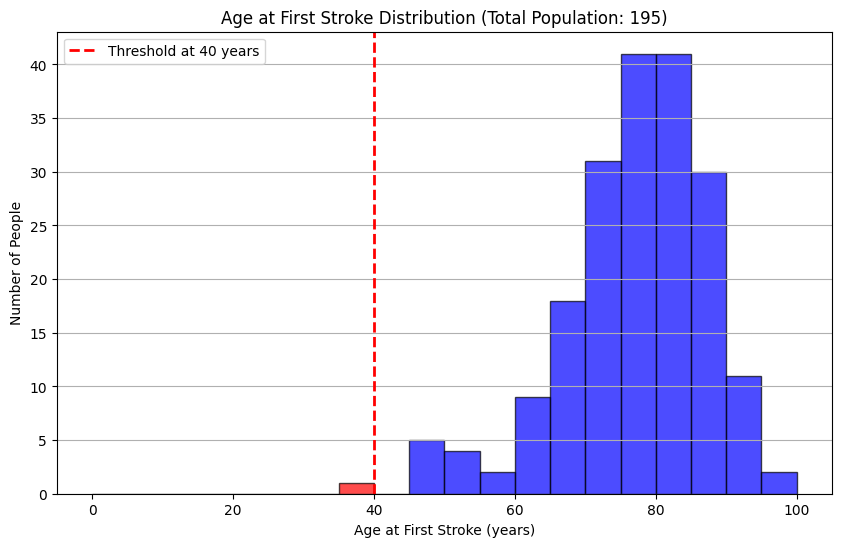

In [ ]:
#prepare data
stroke_data_filtered = enhanced_cases_medical[(enhanced_cases_medical['is_stroke_record'] == 1) &
                                              (enhanced_cases_medical['patient_id'].isin(filtered_unique_subjects['patient_id']))]
first_stroke_ages = stroke_data_filtered.drop_duplicates(subset='patient_id')['age_at_first_stroke']

#total population
total_population = first_stroke_ages.dropna().count()

plt.figure(figsize=(10, 6))

#bins range 5 years
bins = range(0, int(first_stroke_ages.max()) + 5, 5)
n, bins, patches = plt.hist(first_stroke_ages.dropna(), bins=bins, edgecolor='black', alpha=0.7)

#iterate through bins
threshold = 40
for i in range(len(patches)):
  if bins[i] < threshold:
    patches[i].set_facecolor('red')
  if bins[i] >= threshold:
      patches[i].set_facecolor('blue')

# Add threshold line
plt.axvline(x=threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold at {threshold} years')

plt.title(f'Age at First Stroke Distribution (Total Population: {total_population})')
plt.xlabel('Age at First Stroke (years)')
plt.ylabel('Number of People')
plt.grid(axis='y')
plt.legend()
plt.show()

In [ ]:
#filter outlier
potential_outlier = enhanced_cases_medical[(enhanced_cases_medical['is_stroke_record'] == 1) & (enhanced_cases_medical['age_at_first_stroke'] < 40)]
potential_outlier

,medcode,event_date,description,patient_id,line,missing_date_cases_medical,sex,date_of_birth,missing_date_cases_personal,is_stroke_record,age_at_event,age_at_first_stroke
24727,G61z.00,1960-06-04,Intracerebral haemorrhage NOS,20,178,False,1,1921-07-01,False,1,38.0,38.0


We would expect a normal distribution from middle to old age, but we can see there is a disconnected case before 40 years old. This outlier could be queried for further investigation in case it is an error.


## Now we will do the same representation for male and female split of Age of First Stroke Histogram:

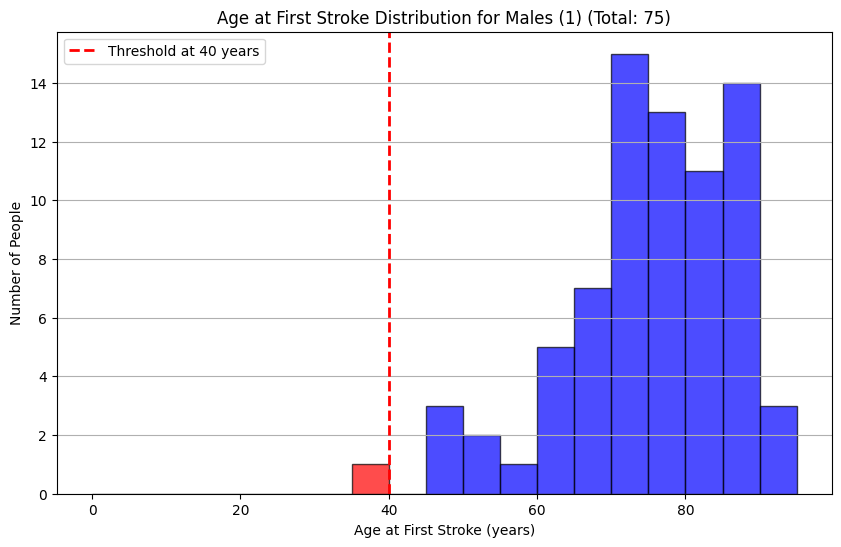

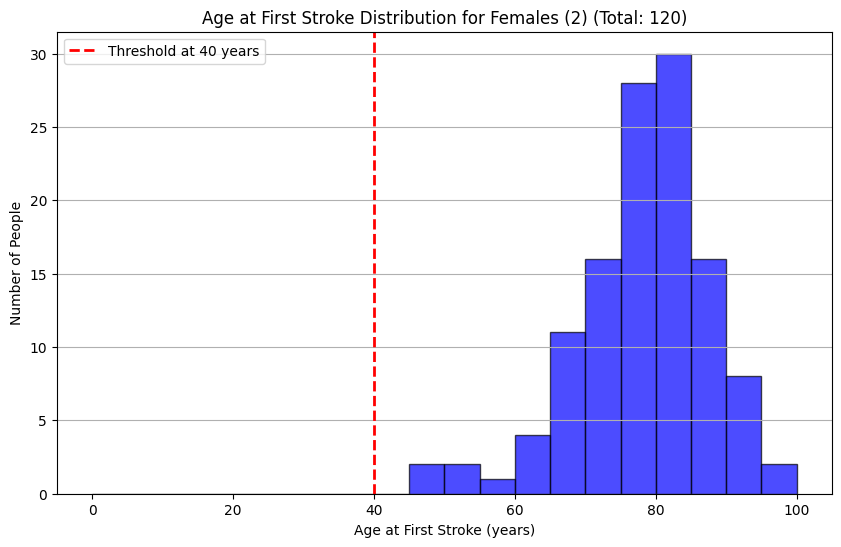

In [ ]:
stroke_data = enhanced_cases_medical[(enhanced_cases_medical['is_stroke_record'] == 1) &
                                              (enhanced_cases_medical['patient_id'].isin(filtered_unique_subjects['patient_id']))]
#print(f"Total stroke records: {stroke_data.shape[0]}")

# Function to plot histogram for a specific sex
def plot_histogram_by_sex(sex_value, sex_label, color):
  #filter by sex
  sex_data = stroke_data[stroke_data['sex'] == sex_value]
  unique_sex_data = sex_data.drop_duplicates(subset='patient_id')
  first_stroke_ages = unique_sex_data['age_at_first_stroke']
  total_subjects = first_stroke_ages.count()

  plt.figure(figsize=(10, 6))

  #bins ramge 5 years
  bins = range(0, int(first_stroke_ages.max()) + 5, 5)

  # Plot histogram
  n, bins, patches = plt.hist(first_stroke_ages.dropna(), bins=bins, edgecolor='black', alpha=0.7)

  #iterate through bins
  threshold = 40
  for i in range(len(patches)):
    if bins[i] < threshold:
      patches[i].set_facecolor('red')
    elif bins[i] >= threshold:
        patches[i].set_facecolor('blue')

  #threshold line
  plt.axvline(x=threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold at {threshold} years')

  plt.title(f'Age at First Stroke Distribution for {sex_label} (Total: {total_subjects})')
  plt.xlabel('Age at First Stroke (years)')
  plt.ylabel('Number of People')
  plt.grid(axis='y')
  plt.legend()
  plt.show()

plot_histogram_by_sex(1, 'Males (1)', 'blue')
plot_histogram_by_sex(2, 'Females (2)', 'pink') # color not working

## Top 5 Most Frequent Types of Strokes (Including Others):

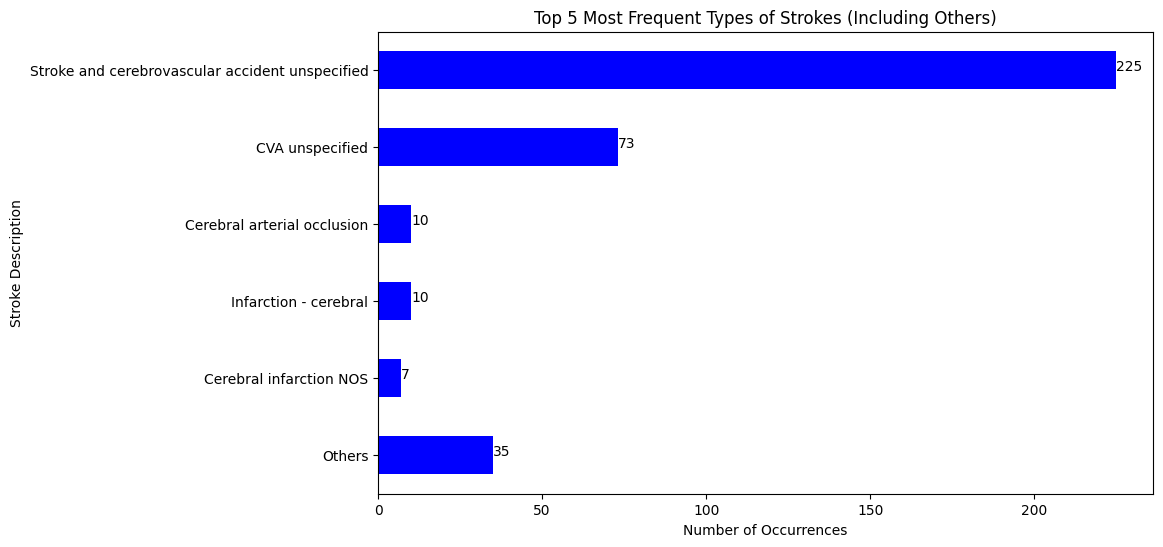

In [ ]:
#filter data
stroke_records = enhanced_cases_medical[enhanced_cases_medical['is_stroke_record'] == 1]
stroke_counts = stroke_records['description'].value_counts()
top_5_strokes = stroke_counts.head(5)

#other
others_count = stroke_counts[5:].sum()
top_5_strokes['Others'] = others_count


plt.figure(figsize=(10, 6))
top_5_strokes.plot(kind='barh', color='blue')

for index, value in enumerate(top_5_strokes):
  plt.text(value, index, str(value))

plt.title('Top 5 Most Frequent Types of Strokes (Including Others)')
plt.xlabel('Number of Occurrences')
plt.ylabel('Stroke Description')
plt.gca().invert_yaxis()  #invert y-axis

plt.show()

## Top 5 Most Frequent Types of Strokes with repetition (Including Others):

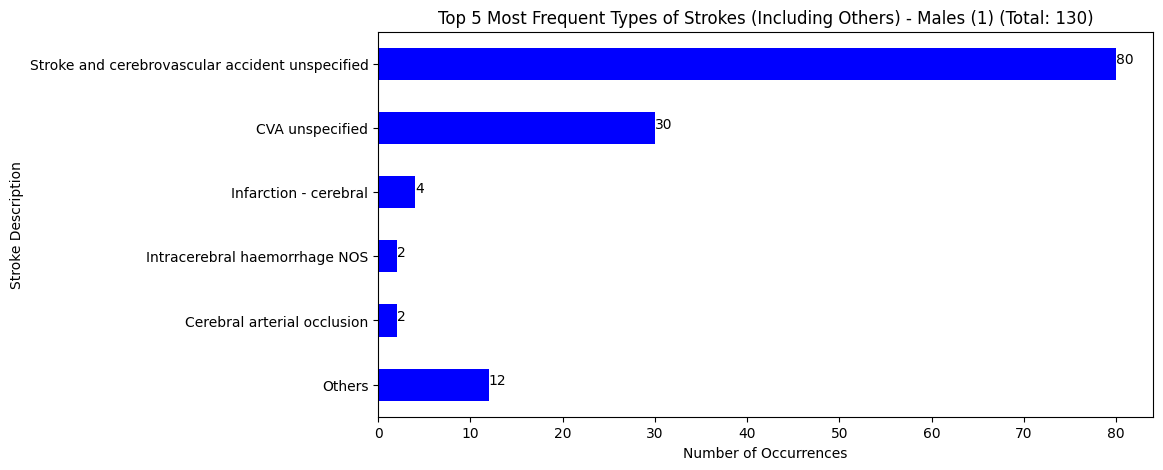

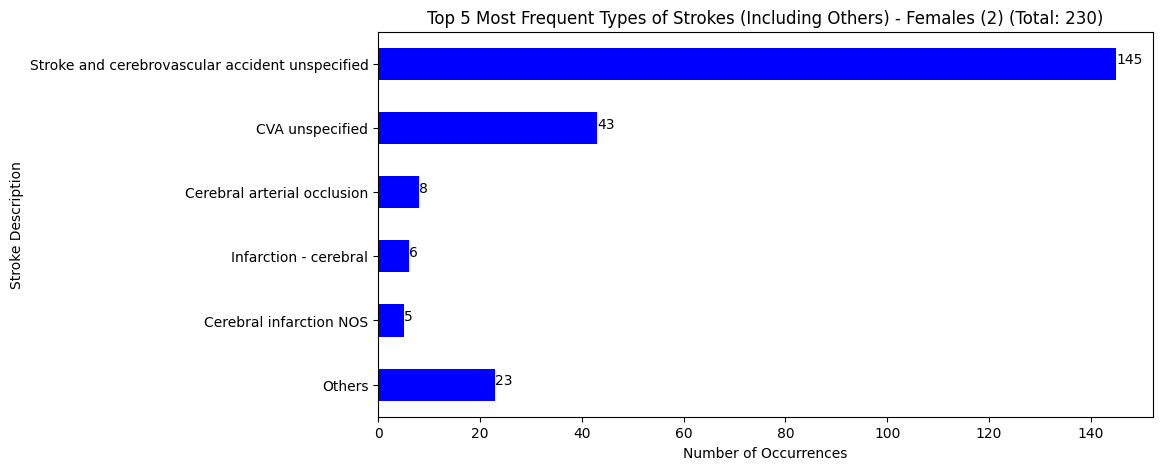

In [ ]:
def plot_top_strokes_by_sex(sex_value, sex_label):
    #filter data
    stroke_records = enhanced_cases_medical[(enhanced_cases_medical['is_stroke_record'] == 1) & (enhanced_cases_medical['sex'] == sex_value)]


    stroke_counts = stroke_records['description'].value_counts()
    top_5_strokes = stroke_counts.head(5)
    #others
    others_count = stroke_counts[5:].sum()
    top_5_strokes['Others'] = others_count

    total_strokes = stroke_counts.sum()


    plt.figure(figsize=(10, 5))
    top_5_strokes.plot(kind='barh', color='blue')

    for index, value in enumerate(top_5_strokes):
        plt.text(value, index, str(value))

    plt.title(f'Top 5 Most Frequent Types of Strokes (Including Others) - {sex_label} (Total: {total_strokes})')
    plt.xlabel('Number of Occurrences')
    plt.ylabel('Stroke Description')
    plt.gca().invert_yaxis()  #invert y-axis

    plt.show()


plot_top_strokes_by_sex(1, 'Males (1)')
plot_top_strokes_by_sex(2, 'Females (2)')

## Top 5 Most Frequent Types of Strokes without repetition (Including Others):

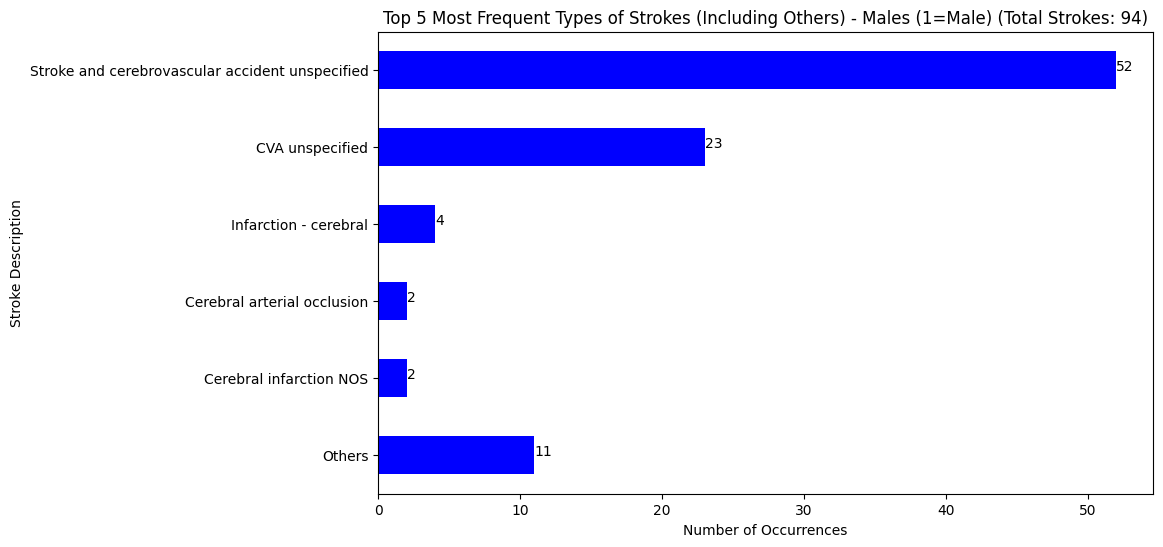

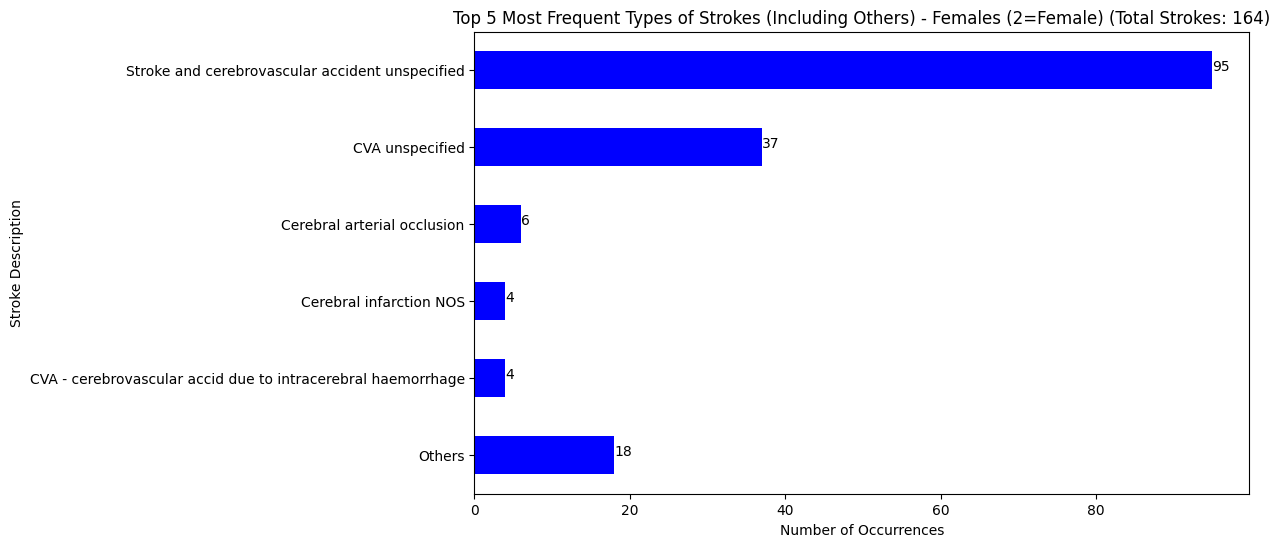

In [ ]:
def plot_top_strokes_by_sex(sex_value, sex_label):
    stroke_records = enhanced_cases_medical[(enhanced_cases_medical['is_stroke_record'] == 1) & (enhanced_cases_medical['sex'] == sex_value)]
    stroke_counts = stroke_records.groupby('description')['patient_id'].nunique().sort_values(ascending=False)

    top_5_strokes = stroke_counts.head(5)

    # others
    others_count = stroke_counts[5:].sum()
    top_5_strokes['Others'] = others_count

    total_strokes = stroke_counts.sum()

    plt.figure(figsize=(10, 6))
    top_5_strokes.plot(kind='barh', color='blue')

    for index, value in enumerate(top_5_strokes):
        plt.text(value, index, str(value))

    plt.title(f'Top 5 Most Frequent Types of Strokes (Including Others) - {sex_label} (Total Strokes: {total_strokes})')
    plt.xlabel('Number of Occurrences')
    plt.ylabel('Stroke Description')
    plt.gca().invert_yaxis()  #invert y-axis

    plt.show()

#males
plot_top_strokes_by_sex(1, 'Males (1=Male)')
#females
plot_top_strokes_by_sex(2, 'Females (2=Female)')

Note: From 3rd to 5th reason of stroke the order changes depending on the sex.

## Proportion of strokes split female/male:  

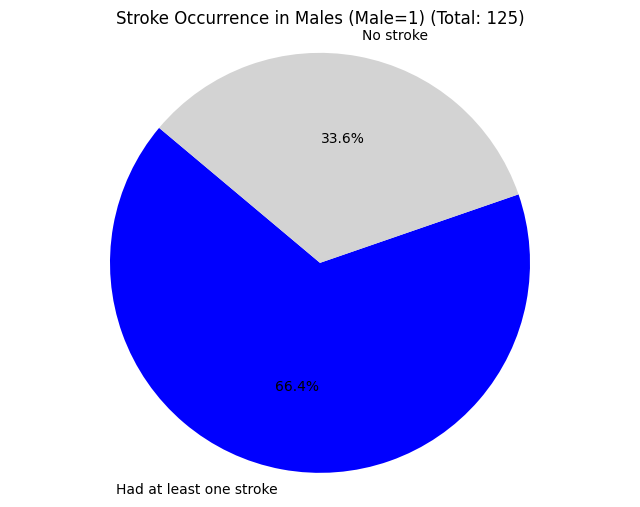

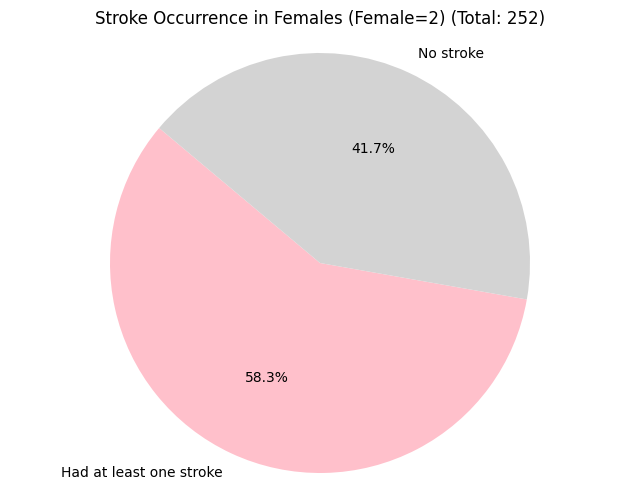

In [ ]:
def plot_stroke_pie_chart(sex_value, sex_label, colors):
  #filter
  sex_data = enhanced_cases_medical[enhanced_cases_medical['sex'] == sex_value]

  #total unique subjects
  total_subjects = sex_data['patient_id'].nunique()

  #with at least one stroke
  stroke_subjects = sex_data[sex_data['is_stroke_record'] == 1]['patient_id'].nunique()

  #percentages
  stroke_percentage = (stroke_subjects / total_subjects) * 100
  no_stroke_percentage = 100 - stroke_percentage


  sizes = [stroke_percentage, no_stroke_percentage]
  labels = ['Had at least one stroke', 'No stroke']

  plt.figure(figsize=(8, 6))
  plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
  plt.title(f'Stroke Occurrence in {sex_label} (Total: {total_subjects})')
  plt.axis('equal')
  plt.show()

#male
plot_stroke_pie_chart(1, 'Males (Male=1)', ['blue', 'lightgray'])
#female
plot_stroke_pie_chart(2, 'Females (Female=2)', ['pink', 'lightgray'])

Although the proportion of females is greater than that of males, the proportion of males with at least one stroke is significantly higher than that of females.

## Other Conclusions

We observed significant inconsistencies in the way event descriptions are logged in the dataset. This inconsistency necessitates grouping similar descriptions, as demonstrated in the "stroke_code" dataset.

### Examples of potentially valuable analyses include:

- High blood pressure versus at least one stroke
- Smoking status versus at least one stroke

### As an illustration, here are various event descriptions related to smoking:

- Current smoker
- Ex smoker
- Smoker
- Cigar smoker
- Not a passive smoker
- Current non-smoker
- Smoke inhalation
- Non-smoker
- Ex-smoker - amount unknown
- Never smoked tobacco
- Passive smoker
